# Quantum Approximate Optimisation for Boolean Satisfiability #
$$
\newcommand{\bra}[1]{\langle #1|}
\newcommand{\ket}[1]{|#1\rangle} 
\newcommand{\ketx}{\ket{\u{x}}} 
\newcommand{\brax}{\bra{\u{x}}} 
\newcommand{\R}[1]{\mathbb{R}^{#1}}
\newcommand{\M}[2]{\mathbb{R}^{#1 \times #2}}
\newcommand{\ux}{\underline{x}}
\newcommand{\u}[1]{\underline{#1}}
\newcommand{\ut}[1]{\underline{#1}^T}
\newcommand{\minb}{\min\limits_{\u{x} \in \{0, 1 \}^n}}
\newcommand{\maxb}{\max\limits_{\u{x} \in \{0, 1 \}^n}}
\newcommand{\sumb}{\sum\limits_{\u{x} \in \{0, 1 \}^n}}
\newcommand{\sumbn}[1]{\sum\limits_{\u{x} \in \{0, 1 \}^{#1}}}
\newcommand{\bn}{\{0, 1\}}
\newcommand{\Z}{\hat{\sigma}^z}
\newcommand{\X}{\hat{\sigma}^x}
\newcommand{\be}{\begin{equation}\begin{split}}
\newcommand{\en}{\end{split}\end{equation}}
$$

Andrew Elkadi, Roberto Bondesan

In [26]:
!pip install qiskit ipywidgets pylatexenc pysat

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

from itertools import combinations
from typing import Dict, List
from scipy.optimize import minimize

# Adiabatic Quantum Computing #

*Adiabatic theorem:* If the Hamiltonian of a quantum state is perturbed slowly enough, the system will remain in its initial eigenstate.

I defer the formalisms and proofs to my Quantum Mechanics II module!

Adiabatic Quantum Computing:

1. Encode problem as a Hamiltonian $\hat{H}_P$ whose ground state is the problem solution
2. Prepare the quantum system in the ground state of a simple Hamiltonian $\hat{H}_S$
3. Adiabatically (slowly) evolve $\hat{H}(t) = (1 - \frac{t}{T})\hat{H}_S + \frac{t}{T}\hat{H}_P $

I.e. we are left in the problem solution state if we evolve slowly enough.

## Trotterization ##

But how do we acually evolve a system under such a $\hat{H}(t)$?

Consider a Hamiltonian $\hat{H}_A = \hat{H}_B + \hat{H}_C$.

The corresponding unitary evolution operator is: $$\hat{U}_A = e^{\frac{it}{\hbar}\hat{H}_A} = e^{\frac{it}{\hbar}(\hat{H}_B + \hat{H}_C)} = e^{\frac{it}{\hbar}\hat{H}_B}e^{\frac{it}{\hbar}\hat{H}_C} \iff [\hat{H}_B, \hat{H}_C] = 0$$

In situations where $[\hat{H}_B, \hat{H}_C] \neq 0$, we resort to the Trotter-Suzuki expansion:

$$e^{\frac{it}{\hbar}(\hat{H}_B + \hat{H}_C)} = \lim\limits_{\tau \rightarrow \infty}(e^{\frac{i}{\hbar}\hat{H}_B\frac{t}{\tau}}e^{\frac{i}{\hbar}\hat{H}_C\frac{t}{\tau}})^\tau$$

Allowing us to approximate:

$$e^{\frac{it}{\hbar}(\hat{H}_B + \hat{H}_C)} \approx (e^{\frac{i}{\hbar}\hat{H}_B\frac{t}{\tau}}e^{\frac{i}{\hbar}\hat{H}_C\frac{t}{\tau}})^\tau$$ for some $\tau \in \mathbb{R}^+$

I.e we mimic the sum of the Hamiltonians by evolving the system in an alternating fashion.

# Quadratic Programs #
A quadratic program is an optimsation problem with:

*   A quadratic objective function
*   Linear and quadratic constraints

Formally:

$$\min\limits_{\u{x} \in \R{n}} \ut{x}Q\u{x} + \ut{c} \u{x}$$

subject to:

$$ A\u{x} \preccurlyeq \u{b}$$

where: $\space Q \in \M{n}{n} \space \text{symmetric}, \space \u{c} \in \R{n}, A \in \M{m}{m}, \space \u{b} \in \R{m}$

N.B. $\preccurlyeq$ is component wise comparison.

## Quadratic Unconstrained Binary Optimisation (QUBO) ##

This is a special case of a quadratic program, where:


*   There are no constraints
*   Binary variables are considered for optimisation

Formally:

$$\minb \space \ut{x}Q\u{x} + \ut{c} \u{x}$$

where: $\space Q \in \M{n}{n} \text{symmetric}, \space \u{c} \in \R{n}$



# Quantum Approximate Optimisation Algorithm (QAOA)#

QAOA finds approximate solutions for optimisation problems by encoding the objective function as a Hamiltonian.

It is a layerised variational form based on the trotterised adiabatic process and an instance of a Variational Quantum Eigensolver (VQE).

N.B. An approximation algorithm for a minimisation problem is *k-optimal* if it guarantees a solution which is not more than *k* times optimal than the true solution.

Classically, it is *NP-Hard* to be more than *0.941-optimal*.



## Overview of QAOA ##

We take inspiration from Adiabatic Quantum Computing which we briefly explored above.

We encode some cost function $C(\u{x})$ as a hamiltonian $\hat{H}_{cost}$ s.t:

$$\hat{H}_{cost} \ket{x} = C(\u{x})\ketx$$

where $\ketx$ is the computational basis state corresponding to $\u{x}$.

Finding 

$$\minb C(\u{x})$$ 

corresponds to finding 

$$\minb \brax \hat{H}_{cost} \ketx$$ 

We reformulate this as a maximisation problem

$$\maxb \brax \hat{H}_C \ketx$$

where $\hat{H}_C = - \hat{H}_{cost}$

In other words, we seek the highest energy state of $\hat{H}_C$ - the equivalent of our adiabatic *problem* hamiltonian $\hat{H}_P$.

Adiabatically, we would evolve the highest energy state of a *simple* hamiltonian $\hat{H}_S$ into the highest energy state of $\hat{H}_C$ to find the solution to the minimisation problem.

QAOA approximates this adiabatic process using the trotterisation we explored above. In this spirit, we consider a *mixer* hamiltonian $\hat{H}_B$ that corresponds to the adiabatic simple hamiltonian $\hat{H}_S$ and define the following unitary operators:

$$\hat{U}_B(\beta) = e^{-i\beta \hat{H}_B} \\
\hat{U}_C(\gamma) = e^{-i\gamma \hat{H}_C} $$ 

Let 

$$\hat{H} = \hat{H}_B + \hat{H}_C$$

The corresponding unitary evolution operator

$$\hat{U}(t) = e^{\frac{-it}{\hbar}\hat{H}} = e^{\frac{-it}{\hbar}(\hat{H}_B + \hat{H}_C)}$$

Is trotterised as: 

$$\hat{U}(t) = e^{\frac{it}{\hbar}(\hat{H}_B + \hat{H}_C)} = \lim\limits_{\tau \rightarrow \infty} (e^{\frac{i}{\hbar}\hat{H}_B\frac{t}{\tau}}e^{\frac{i}{\hbar}\hat{H}_C\frac{t}{\tau}})^\tau$$

Which we approximate as

$$ \hat{U}(t) \approx ∏\limits_{i = 1}^{p}\hat{U}_B(\beta_i)\hat{U}_C(\gamma_i) $$

for some $p \in \mathbb{N}$ as per the earlier section on trotterization.

The QAOA procedure involves iteratively repeating the following, updating $\u{\gamma} = \gamma_1, \dots, \gamma_p$ and $\u{\beta} = \beta_1, \dots, \beta_p$ until some convergence criteria is met in relation to minimising the objective function:
1.   Preparation of the highest energy state $\ket{s}$ of $\hat{H}_B$
2.   $p$ applications of the cost and mixing *layers* in an alternating fashion to form $\ket{\u{\gamma}, \u{\beta}}_p = ∏\limits_{i = 1}^{p}\hat{U}_B(\beta_i)\hat{U}_C(\gamma_i)\ket{s}$
3.   Calculate $\bra{\u{\gamma}, \u{\beta}}\hat{H}_C\ket{\u{\gamma}, \u{\beta}}_p$ 

Using
$$\ket{\u{\gamma}, \u{\beta}}_p = ∏\limits_{i = 1}^{p}\hat{U}_B(\beta_i)\hat{U}_C(\gamma_i)\ket{s}$$
let 
$$F_p = \bra{\u{\gamma}, \u{\beta}}\hat{H}_C\ket{\u{\gamma}, \u{\beta}}_p$$
we define:
$$M_p = \max\limits_{\u{\gamma},\u{\beta}} F_p$$

Note that: 
$$M_{p+1} \geq M_p$$ 

because increasing the depth of the circuit can only mean access to a larger Hilbert space.

By adiabatic considerations:

$$\lim\limits_{p \rightarrow \infty} M_p = \minb C(\u{x}) $$

but these considerations give no guarantees for finite $p$...


## Choosing Hamiltonians ##

An immediate question to consider is why trotterisation is even required. Could we not choose $\hat{H}_C, \hat{H}_B$ s.t. $[\hat{H}_C, \hat{H}_B] = 0$?

In reality, it is exactly the non-commutativity of the hamiltonians that gives QAOA it's *expressivity*. I.e. allows it to explore the Hilbert space.

Recall (Quantum Mechanics 1):

$$[\hat{H}_C, \hat{H}_B] = 0 \Rightarrow \hat{H}_C, \hat{H}_B \space \text{share a common eigenbasis.} $$

I.e. choosing $[\hat{H}_C, \hat{H}_B] = 0$ would only affect the global phases of states in our circuit, which would result in no impact to the measurement outcomes.



### Mixer Hamiltonians ###

While not neccessary, many QAOA algorithms choose:

$$\hat{H}_B = \sum\limits_{i = 1}^n \X_i $$

with corresponding $\ket{+}^n = \frac{1}{\sqrt{2^n}} \sumb \ketx$ the highest energy eigenstate.

The unitary operator that corresponds to this is as follows:

$$\hat{U}_B(\beta) = e^{-i\beta \hat{H}_B} = e^{-i\beta \sum\limits_{i = 1}^n \X_i } = \prod\limits_{i = 1}^n e^{-i\beta\X_i} = \prod\limits_{i = 1}^n R_{X_i}(2\beta)$$

Where $R_{X_i}(\theta)$ is the operator corresponding to a rotation of the $i^{th}$ qubit by $\theta$ about the x-axis on the bloch sphere and we've used the fact that $[\X_i, \X_j] = 0$

As a circuit (where we let $n = 3$):


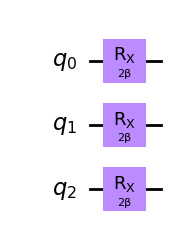

In [27]:
n = 3
mixer = QuantumCircuit(n)
angle = Parameter("2β")
for qubit in mixer.qubits:
  mixer.rx(angle, qubit)

mixer.draw("mpl")

### Cost Hamiltonians for QUBO instances ###

We seek to encode 

$$C(\u{x}) := \ut{x}Q\u{x} + \ut{c} \u{x} $$ 

as a hamiltonian $\hat{H}_{cost}$ s.t:

$$\hat{H}_{cost} \ket{x} = C(\u{x})\ketx$$

where $\ketx$ is the computational basis state corresponding to $\u{x}$.

Recall the Pauli-Z operator:

$$ \Z = \ket{0}\bra{0} - \ket{1}\bra{1} $$

We consider the multi qubit version, s.t:

$$ \Z_i \ketx = (-1)^{x_i}\ketx = (1 - 2x_i)\ketx$$

$$\Rightarrow \frac{1}{2}(\mathbb{I} - \Z_i)\ketx = \frac{1}{2}(1 - (1 - 2x_i))\ketx = x_i\ketx $$

Define $\hat{\chi}_i = \frac{1}{2}(\mathbb{I} - \Z_i)$ and let

$$ \hat{H}_{cost} = \sum_{i, j = 1}^n Q_{ij}\hat{\chi}_i \hat{\chi}_j + \sum_{i = 1}^n c_i\hat{\chi}_i$$

It is clear that

$$\hat{H}_{cost} \ket{x} = C(\u{x})\ketx$$

We will explore other problem instances (higher order than QUBO) further on in this notebook.

We expand and group $\hat{H}_{cost}$ in quadratic, linear and constant terms:

$$\hat{H}_{cost} = \sum\limits_{i, j = 1}^n \frac{1}{4} Q_{ij}\Z_i\Z_j -\sum\limits_{i, j = 1}^n \frac{1}{4} Q_{ij}(\Z_i + \Z_j) + \frac{1}{2}c_i\Z_i + \left(\sum\limits_{i, j = 1}^n \frac{1}{4} Q_{ij} + \sum\limits_{i = 1}^n \frac{1}{2}c_i\right)\mathbb{I}$$ 

The constant term does not change the minimisation problem since it adds the same value to every eigenvalue, so we can ignore it.

$$
\be
\rightarrow \hat{H}_{cost} &= \sum\limits_{i, j = 1}^n \frac{1}{4} Q_{ij}\Z_i\Z_j -\sum\limits_{i, j = 1}^n \frac{1}{4} Q_{ij}(\Z_i + \Z_j) + \frac{1}{2}c_i\Z_i \\
&= \sum\limits_{i, j = 1}^n \frac{1}{4} Q_{ij}\Z_i\Z_j -\sum\limits_{i, j = 1}^n \frac{1}{2} (Q_{ij} + c_i)\Z_i \\
\Rightarrow \hat{H}_C &= \sum\limits_{i, j = 1}^n \frac{1}{2} (Q_{ij} + c_i)\Z_i - \sum\limits_{i, j = 1}^n \frac{1}{4} Q_{ij}\Z_i\Z_j 
\en$$

where we've used the fact that $Q$ is symmetric to simplify
$$\sum\limits_{i, j = 1}^n \frac{1}{4} Q_{ij}(\Z_i + \Z_j) = \sum\limits_{i, j = 1}^n \frac{1}{2}Q_{ij}\Z_i$$

The unitary operator that corresponds to this, is as follows:

$$
\begin{equation}
\begin{split}
\hat{U}_C(\gamma) 
= e^{-i\gamma \hat{H}_C} &= e^{i\gamma \left(\sum\limits_{i, j = 1}^n \frac{1}{4} Q_{ij}\Z_i\Z_j -\sum\limits_{i, j = 1}^n \frac{1}{2} (Q_{ij} + c_i)\Z_i\right)} \\
&= \prod\limits_{i,j = 1}^n e^{i\gamma \frac{1}{4} Q_{ij}\Z_i\Z_j}\prod\limits_{i, j = 1}^n e^{-i\gamma \frac{1}{2} (Q_{ij} + c_i)\Z_i} \\
&= \prod\limits_{i, j, k, l = 1}^n R_{Z_iZ_j}\left(-\frac{1}{2}Q_{ij}\gamma\right)R_{Z_k}\left(\gamma\sum\limits_{l = 1}^n Q_{kl} + c_k\right) \\
:&= \prod\limits_{i, j, k, l = 1}^n R_{Z_iZ_j}(\omega_{ij}\gamma)R_{Z_k}(\Omega_{k}\gamma)
\end{split}
\end{equation}
$$

Where:
* $R_{Z_i}(\theta)$ is the operator corresponding to a rotation of the $i^{th}$ qubit by $\theta$ about the z-axis on the bloch sphere
* $R_{Z_iZ_j}(\theta)$ is the operator corresponding to a rotation of the $j^{th}$ qubit by $\theta$ about the z-axis on the bloch sphere, controlled by the $i^{th}$ qubit
* We've used the fact that $[\Z_i, \Z_j] = 0$

As a circuit (where we let $n = 3$):



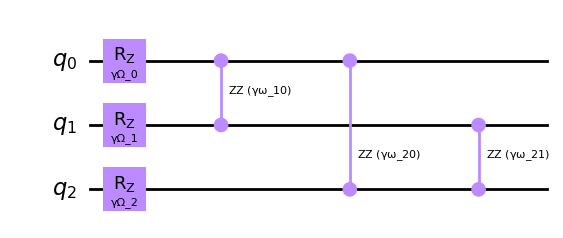

In [28]:
# N.B. this is simply for demonstration purposes, we would actually only have
# gamma and as a parameter and multiply the omegas within the gates

n = 3
cost = QuantumCircuit(n)
params_single = [Parameter(f'γΩ_{i}') for i in range(n)]
params_control = [Parameter(f'γω_{i}{j}') for i in range(n) for j in range(i)]

for (param, qubit) in zip(params_single, cost.qubits):
  cost.rz(param, qubit)

qubit_pairs = combinations(cost.qubits, 2)
controlled_rotations = zip(params_control, qubit_pairs)

for (param, (qubit1, qubit2)) in controlled_rotations:
  cost.rzz(param, qubit1, qubit2)

cost.draw("mpl")

## QAOA Circuit ##

Piecing together our circuits above along with the preparation of our initial state, we construct the following circuit (where we let $n = 3$ and $p=1$).



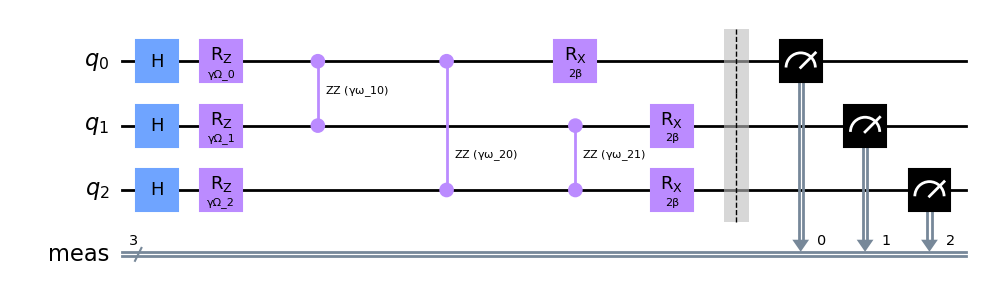

In [29]:
n = 3
qaoa = QuantumCircuit(n)

# Prepare initial state with Hadamard gates
for qubit in qaoa.qubits:
  qaoa.h(qubit)

qaoa.compose(cost, inplace=True)
qaoa.compose(mixer, inplace=True)
qaoa.measure_all()
qaoa.draw("mpl")

## Examples of QAOA Applications ##

We will now explore a number of QAOA approaches to graph theoretic problems.

We will use `networkX` to define and visualise the graphs:

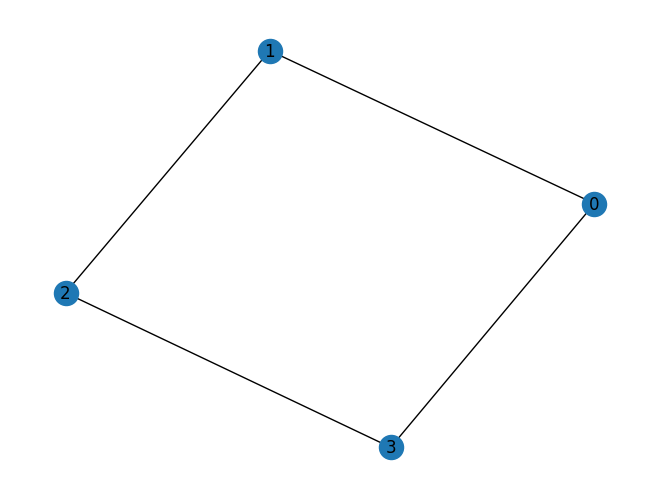

In [30]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True)

### MaxCut ###

A *cut* is a partition of vertices of a graph into two disjoint sets.

The *weight* of a cut is the sum of the weights of the edges connecting vertices between the two sets.

The *max cut* is the cut with the maximal weight.



#### Encoding MaxCut as a QUBO problem ####

Consider a graph $G$ s.t. $|G| = n$.

We encode a cut on $G$ into two sets $A$ and $B$ as a bistring $\u{x} = \{0, 1\}^n$. Where: 
$$x_i = 0 \iff i^{th} \space \text{node} \in A \\
x_i = 1 \iff i^{th} \space \text{node} \in B$$

Let $W^G$ the adjaceny matrix of $G$, where $W^G_{ij}$ is the weight of edge $(i, j) \in G$.

Using this encoding, our MaxCut problem becomes:

$$\minb \sum\limits_{i,j=1}^nW_{ij}x_i(1-x_j) := \minb C(\u{x})$$

To formulate this as a QUBO problem, consider:

$$ \begin{equation}
\begin{split}
\minb \sum_{i, j = 1}^n W_{ij}x_i(1-x_j) 
&= \minb \sum_{i, j = 1}^n -W_{ij}x_ix_j + \sum_{i, j = 1}^n W_{ij}x_i \\
&= \minb -\ut{x}W\u{x} + \ut{e} W^T \u{x}
\end{split} 
\end{equation}$$

where $\u{e} = \{1\}^n $

Letting $Q = -W$ and $\u{c} = W\u{e}$ we retrieve a QUBO problem.

This means that $\u{c}_i$ is the number of edges connected to node $i$.



#### Constructing the MaxCut QAOA Circuit ####

Using the formulations in the previous section along with our encoding of MaxCut as a QUBO, we define the following method to construct our quantum circuit.

In what follows, we will assume the graph is unweighted $\Rightarrow W_{ij} = \{0, 1\}^{n \times n}$.

From our QUBO formulation of the problem, we have: $Q = -W$ and $\u{c} = W\u{e}$ in  
$$\hat{U}_C(\gamma) = \prod\limits_{i, j, k, l = 1}^n R_{Z_iZ_j}\left(-\frac{1}{2}Q_{ij}\gamma\right)R_{Z_k}\left(\gamma\sum\limits_{l = 1}^n Q_{kl} + c_k\right) \\
 := \prod\limits_{i, j, k, l = 1}^n R_{Z_iZ_j}(\omega_{ij}\gamma)R_{Z_k}(\Omega_{k}\gamma)$$

$$\Rightarrow \omega_{ij} = \frac{1}{2}W_{ij}, \\
\Omega_k = -\sum\limits_{l = 1}^n W_{kl} + W\u{e}_k = 0$$

This means out circuit does not need an $R_z$ gates nor $R_{zz}$ gates for disconnected nodes.



In [31]:
def construct_circuit(G: nx.Graph, p: int) -> QuantumCircuit:
  n = G.number_of_nodes()
  maxcut = QuantumCircuit(n)
  
  # Prepare initial state with Hadamard gates
  for qubit in maxcut.qubits:
    maxcut.h(qubit)
  
  # Creat p alternating mixer and cost gates
  for i in range(p):
    
    # Two qubit cost gates (1/2 because 1/2 * Wij)
    gamma = Parameter(f"y_{i}")
    for (q1, q2) in G.edges():
      maxcut.rzz(0.5 * gamma, q1, q2)

    # Mixer gates
    beta = Parameter(f"β_{i}")
    for qubit in maxcut.qubits:
      maxcut.rx(2 * beta, qubit)
  
  maxcut.measure_all()
  return maxcut

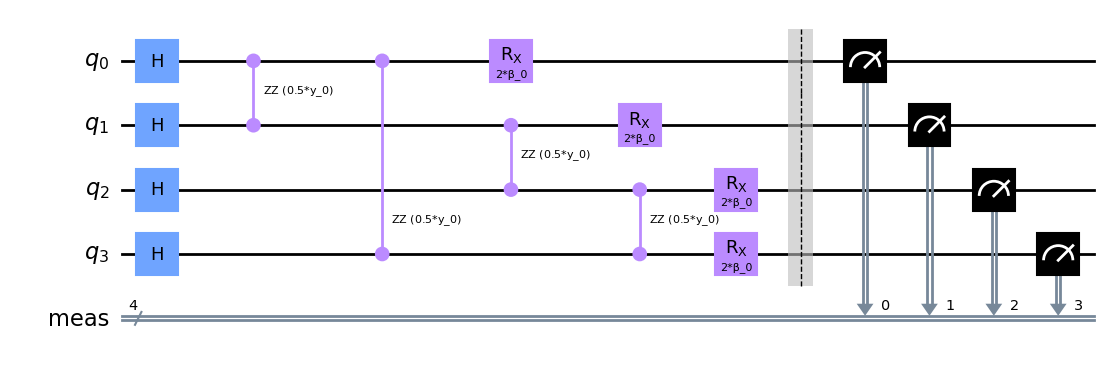

In [32]:
c = construct_circuit(G, p=1)
c.draw("mpl")

#### Running the QAOA algorithm ####

We will first define some helper functions.


In [33]:
# Nodes are in different sets iff sum in bistring is 1
def cut_weight(x: str, G: nx.Graph) -> int:
  """ Calculate the weight of a cut on a graph."""
  return sum([(int(x[a]) + int(x[b]) % 2) for (a, b) in G.edges()])

def cut_weighted_average(counts: Dict[str, int], G: nx.Graph) -> float:
  """ Calculate average of cut weights across measurements of the circuit."""
  sums = [count * cut_weight(cut, G) for (cut, count) in counts.items()]
  return sum(sums) / sum(counts.values())

On the graph above, we'd expect the cut:
* $0101$ to have weight 4 
* $0001$ to have weight 2
* $0000$ to have weight 0

And the average of these to be $\frac{4 + 2 + 0}{3} = 2$

In [34]:
cuts = ["0101", "0001", "0000"]
for cut in cuts:
  print(f'{cut} has weight {cut_weight(cut, G)}')

print(f'Average cut weight of {cuts} = {cut_weighted_average({cut : 1 for cut in cuts}, G)}')

0101 has weight 4
0001 has weight 2
0000 has weight 0
Average cut weight of ['0101', '0001', '0000'] = 2.0


Finally, we piece these together and run our algorithm to get the parameters that correspond to the max cut. We then use these parameters to find the corresponding string.

In [35]:
def max_cut_params(G: nx.graph, p: int, init_params: List[float]) -> List[float]:
  """ Finds the approximate max cut of a graph"""
  circuit = construct_circuit(G, p)
  backend = Aer.get_backend('qasm_simulator')

  def execute_average(param_values: List[float]) -> float:
    bound_circuit = circuit.bind_parameters(param_values)
    counts = backend.run(bound_circuit).result().get_counts()
    # -1 * average because we want to maximise but are using scipy minimise
    return -1 * cut_weighted_average(counts, G)

  result = minimize(execute_average, init_params, method='COBYLA')

  print(result)

  return result.x

In [36]:
opt_params = max_cut_params(G, p=1, init_params=[1.0, 1.0])

     fun: -3.939453125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([ 2.72674281, -0.78876558])


We bind these final parameters to our circuit and plot the ouput to analyse the possible cuts:

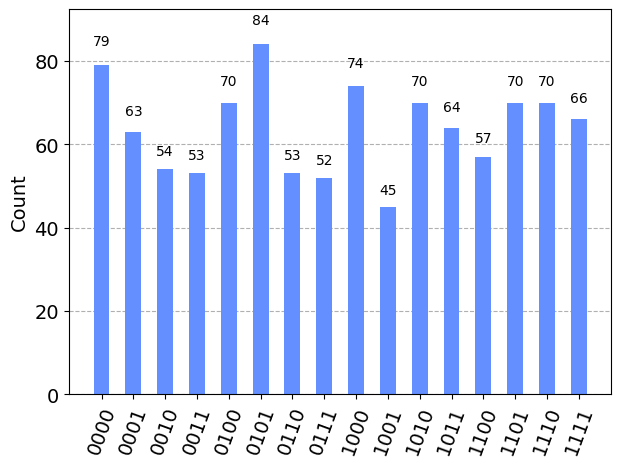

In [37]:
final_circuit = construct_circuit(G, p=1)
final_circuit = final_circuit.bind_parameters(opt_params)
backend = Aer.get_backend('qasm_simulator')
counts = backend.run(final_circuit, shots=1024).result().get_counts()
plot_histogram(counts)

As expected! The max cut on the graph $G$ is done by alternating the nodes, i.e. $0101$ or $1010$:

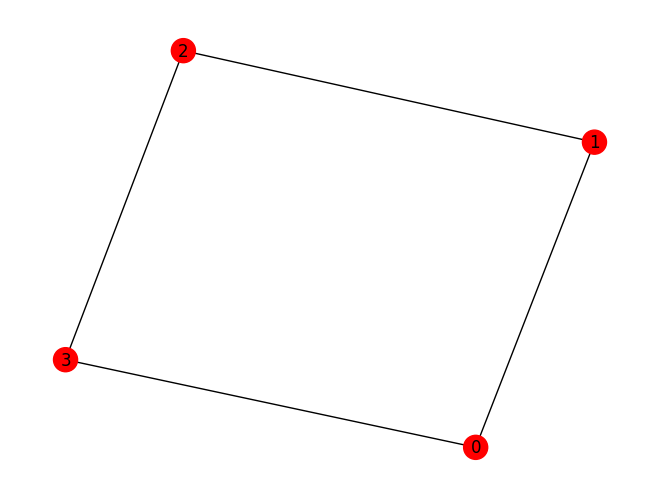

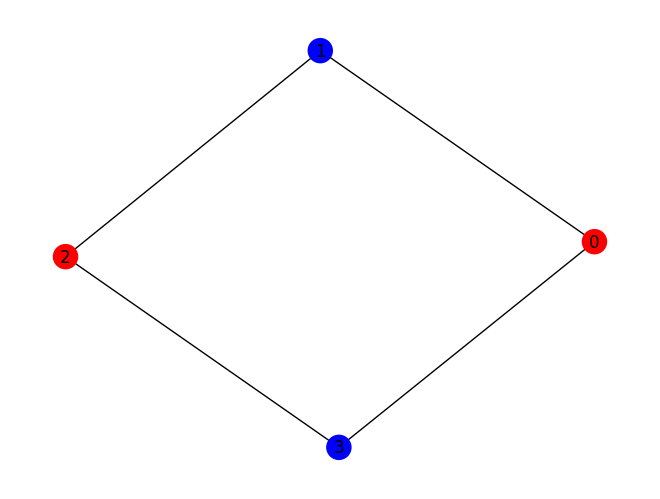

<Figure size 640x480 with 0 Axes>

In [38]:
ordered_cuts = [cut for (cut, _) in sorted(counts.items(), key=lambda item : item[1])]
for cut in ordered_cuts[-2:]:
  color_map = ["red" if i == "0" else "blue" for i in cut] 
  nx.draw(G, node_color=color_map, with_labels=True)
  plt.show()
  plt.clf()

# Representing Functions as Hamiltonians# 

We explored encoding QUBO instances above as Hamiltonians diagonal in the computational basis.

We will explore<a name="cite_ref-1"></a>[<sup>[HAD21]</sup>](#cite_note-1) generalising this encoding to boolean functions 
$\mathcal{B}_n : \bn^n \rightarrow \bn$ and real functions $\mathcal{R}_n : \bn^n \rightarrow \mathbb{R}$ 

A Hamiltonian $\hat{H}_f$ _represents_ $f$ if:

$$ \hat{H}_f\ketx = f(\u{x})\ketx$$

for $\ux \in \bn$ with corresponding computational basis state $\ketx$



## Boolean Functions ##

**Theorem**: For a Boolean function $f : \bn^n \rightarrow \bn$ the unique Hamiltonian $\hat{H}_f$ on $n$ qubits representing $f$ is:

$$ \hat{H}_f = \sum\limits_{S ⊂ [n]} \hat{f}(S) \prod\limits_{j \in S} Z_j = \hat{f}(\emptyset)I + \sum\limits_{j = 1}^n \hat{f}(\{j\})Z_j + \sum\limits_{j < k} \hat{f}(\{j, k\})Z_jZ_k \dots$$

Where the _fourier coefficients_: 

$$\hat{f}(S) = \frac{1}{2^n} \sumb f(\u{x})(-1)^{S ⋅ \u{x}} = \frac{1}{2^n} tr(\hat{H}_f\prod\limits_{j \in S} Z_j) $$

And the following notation has been used:

* $S \cdot \u{x} := \sum\limits_{j \in S} x_j$
* $[n] := \{1, 2, \dots, n\}$
* $ Z_j := I^{⊗(j - 1)} \otimes Z \otimes I^{⊗(n - j)}$ i.e. the Z-pauli operator applied to the $j^{th}$ qubit

**Example**: let $f : \bn^3 \rightarrow \bn, \space f(\u{x}) = x_1 \oplus x_2 \oplus x_3$

$$
\be
\hat{f}(∅) &= \frac{1}{8}\sumbn{3} f(\ux)(-1)^{∅ \cdot \ux} = \frac{1}{8}\sumbn{3} f(\ux) = \frac{1}{2} \\
\hat{f}(\{j\}) &= \frac{1}{8}\sumbn{3} f(\ux)(-1)^{\{j\} \cdot \ux} = \frac{1}{8}\sumbn{3} f(\ux)(-1)^{x_j} = 0 \\
\hat{f}(\{j, k\}) &= \frac{1}{8}\sumbn{3} f(\ux)(-1)^{\{j, k\} \cdot \ux} = \frac{1}{8}\sumbn{3} f(\ux)(-1)^{x_j + x_k} = 0 \\
\hat{f}(\{j, k, l\}) &= \frac{1}{8}\sumbn{3} f(\ux)(-1)^{\{j, k, l\} \cdot \ux} = \frac{1}{8}\sumbn{3} f(\ux)(-1)^{x_j + x_k + x_l} = -\frac{1}{2}
\en
$$

$$ \Rightarrow \hat{H}_f = \sum\limits_{S ⊂ [3]} \hat{f}(S) \prod\limits_{j \in S} Z_j = \frac{1}{2}(I - Z_1Z_2Z_3) $$





**Corollary**: Computing $\hat{f}(∅)$ of $\hat{H}_f$ representing a $SAT$ formula is $\#P\text{-hard}$. 

Recall, for some complexity class $\mathcal{C}$ and problem $P$ 

$$P \in \mathcal{C}\text{-hard} \iff \forall P^\prime \in \mathcal{C}, \space P^\prime \leq P$$ 

where $\leq$ is a p-time reduction.

$\# SAT \in \# PC$ $\Rightarrow$ suffices to show $\# SAT \leq \hat{f}(∅)$

**Corollary**: Deciding if $\hat{f}(∅) = 0$ of $\hat{H}_f$ representing a $SAT$ formula is equivalent to deciding if $f$ is unsatisfiable, in which case $\hat{H}_f$ reduces to 0.

$$0 = \hat{f}(∅) = \frac{1}{2^n} \sumb f(\u{x})(-1)^{∅ ⋅ \u{x}} = \frac{1}{2^n} \sumb f(\u{x}) \\
⇒ 0 = \sumb f(\u{x})$$

$f \in \mathcal{B}_n \Rightarrow f(\ux) = 1$ or $f(\ux) = 0$ (the formula is either satisfied or it isn't), so

$$ \sumb f(\ux) = 0 \iff \forall \ux \in \bn^n \space f(\ux) = 0$$

This is equivalent to deciding if $f(\ux)$ is unsatisfiable.

$$
\be
\forall \ux \in \bn^n \space f(\ux) = 0 ⇒&\forall \ux \in \bn^n \space \hat{H}_f\ketx = 0 \\
⇒&\forall \ux, \ux^\prime \in \bn^n \space \bra{\ux^\prime} \hat{H}_f\ketx = 0
\en
$$

I.e. the matrix representation of $\hat{H}_f$ is the 0 matrix.

This means, given a Boolean function $f$ such that counting its number of satisfying arguments is $P\text{-hard}$, computing $\hat{f}(∅)$ will also be $P\text{-hard}$.

**N.B.** even if we can compute the values of $\hat{f}(S)$, the corresponding $\hat{H}_f$ may require $O(k^n) \space Z\text{-pauli}$ gates, for some $k > 1 \in \mathbb{R}$.

## Constructing Hamiltonians using Propositional Logic ##

While we are able to represent any Boolean function using the above expansion, for situations where our functions are formed as compositions of others, we can leverage the following rules.

We begin by representing $true$ and $false$, $1$ and $0$ respectively:

$$\hat{H}_1 = I \space \\ \hat{H}_0 = 0$$

Where $I$ is the $2^n$ identity matrix and $0$ is the $2^n$ $0$ matrix.

I.e.

$$ \hat{H}_1 \ketx = 1 \times \ketx \\
\hat{H}_0 \ketx = 0 \times \ketx $$

We also define $\hat{H}_{x_j}$ the operation of multiplying $\ketx$ by $x_j \in \ux$. Recalling that $Z = \ket{0}\bra{0} - \ket{1}\bra{1} $

We consider the multi qubit version, where $Z_j := I^{⊗(j - 1)} \otimes Z \otimes I^{⊗(n - j)}$ s.t:

$$ Z_j \ketx = (-1)^{x_j}\ketx = (1 - 2x_j)\ketx$$

$$\Rightarrow \frac{1}{2}(\mathbb{I} - Z_j)\ketx = \frac{1}{2}(1 - (1 - 2x_j))\ketx = x_j\ketx $$

I.e. $\hat{H}_{x_j} = \frac{1}{2} I - \frac{1}{2} Z_j$

**Theorem** Let $f, g \in \mathcal{B}_n$ represented by $\hat{H}_f, \hat{H}_g$, then:
* $\hat{H}_{\neg f} = 1 - \hat{H}_f$
* $\hat{H}_{f \land g} = \hat{H}_f\hat{H}_g$
* $\hat{H}_{f \lor g} = \hat{H}_f + \hat{H}_g - \hat{H}_f\hat{H}_g$
* $\hat{H}_{f \oplus g} = \hat{H}_f + \hat{H}_g -2\hat{H}_f\hat{H}_g$
* $\hat{H}_{f \Rightarrow g} = I - \hat{H}_f + \hat{H}_f\hat{H}_g$
* $\hat{H}_{af + bg} = a\hat{H}_f + b\hat{H}_g$

**Example:** let $f : \bn^3 → \bn, \space f(\ux) = x_1 \land (x_2 \lor x_3)$.

$$
\be
\hat{H}_{x_1} &= \frac{1}{2}I - \frac{1}{2}Z_1 \\ 
\hat{H}_{x_2} &= \frac{1}{2}I - \frac{1}{2}Z_2 \\
\hat{H}_{x_3} &= \frac{1}{2}I - \frac{1}{2}Z_3 \\
⇒ \hat{H}_{x_2 \lor x_3} &= \hat{H}_{x_2} + \hat{H}_{x_3} - \hat{H}_{x_2}\hat{H}_{x_3} \\
&= \frac{1}{2}I - \frac{1}{2}Z_2 + \frac{1}{2}I - \frac{1}{2}Z_3 - \left(\frac{1}{2}I - \frac{1}{2}Z_2\right)\left(\frac{1}{2}I - \frac{1}{2}Z_3\right) \\
&= \frac{3}{4}I - \frac{1}{4}(Z_2 + Z_3 + Z_2Z_3) \\
⇒ \hat{H}_f &= \hat{H}_{x_1 \land (x_2 \lor x_3)} \\
&= \hat{H}_{x_1} \hat{H}_{x_2 \lor x_3} \\
&= \left(\frac{1}{2}I - \frac{1}{2}Z_1\right)\left(\frac{3}{4}I - \frac{1}{4}(Z_2 + Z_3 + Z_2Z_3)\right) \\
&= \frac{3}{8}I + \frac{1}{8}Z_1(Z_2 + Z_3 + Z_2Z_3) - \frac{1}{8}(3Z_1 + Z_2 + Z_3 + Z_2Z_3) \\
&= \frac{3}{8}I - \frac{1}{8}(3Z_1 + Z_2 + Z_3)+ \frac{1}{8}(Z_1Z_2 + Z_1Z_3 - Z_2Z_3) + \frac{1}{8}Z_1Z_2Z_3 
\en
$$

E.g. for $\ux = 101, \space f(\ux) = x_1 \land (x_2 \lor x_3) = 1 \land (0 \lor 1) = 1$  

$$
\be 
\hat{H}_f \ket{101} &= \frac{3}{8}\ket{101} - \frac{1}{8}(-3 + 1 - 1)\ket{101} + \frac{1}{8}(-1 + 1 + 1)\ket{101} + \frac{1}{8}\ket{101} \\
&= \frac{3}{8}\ket{101} + \frac{3}{8}\ket{101} + \frac{1}{8}\ket{101} + \frac{1}{8}\ket{101} \\
&= 1 \times \ket{101}
\en$$

Whereas for $\u{y} = 100, \space f(\u{y}) = y_1 \land (y_2 \lor y_3) = 1 \land (0 \lor 0) = 0$  

$$
\be 
\hat{H}_f \ket{100} &= \frac{3}{8}\ket{100} - \frac{1}{8}(-3 + 1 + 1)\ket{100} + \frac{1}{8}(-1 - 1 - 1)\ket{100} - \frac{1}{8}\ket{100} \\
&= \frac{3}{8}\ket{100} + \frac{1}{8}\ket{100} - \frac{3}{8}\ket{100} - \frac{1}{8}\ket{100} \\
&= 0 \times \ket{100}
\en$$

As expected.

Below is a table of basic composition rules:

\begin{array}{|c|c|c|c|} \hline
f(x) & \hat{H}_f & f(x) & \hat{H}_f \\ \hline
x & \frac{1}{2}I - \frac{1}{2}Z  & \overline{x} & \frac{1}{2} I + \frac{1}{2}Z \\
x_1 \oplus x_2 & \frac{1}{2}I - \frac{1}{2}Z_1Z_2  & ⨁\limits_{j = 1}^{k}x_j & \frac{1}{2}I - \frac{1}{2}\prod\limits_{i=1}^kZ_k \\
x_1 \land x_2 & \frac{1}{4}I - \frac{1}{4}(Z_1 + Z_2 - Z_1Z_2) & ⋀\limits_{j = 1}^{k}x_j & \frac{1}{2^k} \prod\limits_j^k(1 - Z_j)\\
\overline{x_1 x_2} & \frac{3}{4}I - \frac{1}{4}(Z_1 + Z_2 + Z_1Z_2) & ⋁\limits_{j = 1}^{k}x_j & I - \frac{1}{2^k} \prod\limits_j^k(1 + Z_j) \\
x_1 \lor x_2 & \frac{3}{4}I + \frac{1}{4}(Z_1 + Z_2 - Z_1Z_2) & x_1 \Rightarrow x_2 & \frac{3}{4}I + \frac{1}{4}(Z_1 - Z_2 + Z_1Z_2) \\ \hline
\end{array}



## Pseudo-Boolean/Real Functions ##

While $f \in \mathcal{B}_n$ requires $O(k^n)$ gates, when a Boolean clause $f^\prime$ acts on only $m < n$ bits where $m$ is constant or $O(\log n)$ we may efficiently construct $\hat{H}_{f^\prime}$. We term $f^\prime$ a Pseudo-Boolean function. In this case, $\hat{H}_{f^\prime}$ has $\leq 2^m$ non-zero terms.

Consider $g \in \mathcal{R}_n$

$$ g(x) = \sum\limits_{j = 1}^l w_jf_j(x) $$

$w_j \in \mathbb{R}$, $\space l = \text{poly}(n)$. 

This is a *Pseudo-Boolean* function: a weighted sum of $f_j \in \mathcal{B}_{m < n}$ (Boolean functions that acts on a subset of the $n$ bits).

**Theorem**: For $g \in \mathcal{R}_n$, the *unique* Hamiltonian representing $g$ is $\hat{H}_g$ s.t:

$$\hat{H}_g = \sum\limits_{S ⊂ [n]}\hat{g}(S) \prod_{j \in S} Z_j$$

where the _fourier coefficients_: 

$$\hat{g}(S) = \frac{1}{2^n} \sumb g(\u{x})(-1)^{S ⋅ \u{x}} = \frac{1}{2^n} tr(\hat{H}_g\prod\limits_{j \in S} Z_j) $$

And the following notation has been used:

* $S \cdot \u{x} := \sum\limits_{j \in S} x_j$
* $[n] := \{1, 2, \dots, n\}$
* $ Z_j := I^{⊗(j - 1)} \otimes Z \otimes I^{⊗(n - j)}$ i.e. the Z-pauli operator applied to the $j^{th}$ qubit

In particular, for a *Pseudo-Boolean* function, $ g(x) = \sum\limits_{j = 1}^l w_jf_j(x), \space w_j \in \mathbb{R}$, $\space l = \text{poly}(n)$. 

$$\hat{H}_g = \sum\limits_{j = 1}^l w_j\hat{H}_{f_j} \\
\hat{g}(S) = \sum\limits_{j}w_j\hat{f_j}(S) \in \mathbb{R}$$

# QAOA for MAX-SAT #

Building on the previous section, we will explore applying QAOA to the MAX-SAT problem, defined as follows:

Let $\{(c_i, w_i)\}$ be a set of Boolean clauses with associated non-negative weights on variables $\{x_i\}$ where $c_i$ is a disjunction of literals $\{x_i, ¬x_i\}$. Find an assignment on $\{x_i\}$ s.t. the total weight of satisfied clauses is maximised.

MAX-SAT is NP-complete, as is MAX-2-SAT.

Recall that 3-SAT ~ SAT, i.e. we can map any MAX-SAT problem to a MAX-3-SAT problem.

<font color="Orange"> Slightly confused why we map SAT to 3SAT problems. According to [APMB20], "there exists problem instances of
high-density that appear not to be accessible". Since clause density is defined as $m/n$ where $m$ is the number of clauses and $n$ the number of variables, are not just increasing $m$ by mapping to 3SAT, i.e. increasing the clause density and making our problem harder? Or as we not really mapping but instead choosing 3SAT because it is a standarised format and we can map anything to it if need be?</font>

We define some utility classes for later use:

In [39]:
from functools import reduce
class Variable:
  def __init__(self, index: int, is_negation: bool) -> None:
    self.index = index
    self.is_negation = is_negation

  def __repr__(self) -> str:
    return f'¬x{self.index}' if self.is_negation else f'x{self.index}'

  def __str__(self) -> str:
    return f'¬x{self.index}' if self.is_negation else f'x{self.index}'

  def is_satisfied(self, assignment: str) -> bool:
    ass = bool(int(assignment[self.index]))
    return (self.is_negation and not ass) or (not self.is_negation and ass) 

class Clause:
  def __init__(self, variables: List[Variable], weight: float) -> None:
    self.variables = variables
    self.weight = weight

  def __repr__(self) -> str:
    return '(' + ' ∨ '.join([v.__str__() for v in self.variables]) + ')'

  def __str__(self) -> str:
    return '(' + ' ∨ '.join([v.__str__() for v in self.variables]) + ')'

  def get_variable(self, index: int) -> Variable:
    return self.variables[index]

  def is_satisfied(self, assignment: str) -> bool:
    return any([v.is_satisfied(assignment) for v in self.variables])

  def parity(self, vars: List[Variable] = None) -> int:
    if vars is None:
      vars = self.variables
    r = reduce(lambda x, y : x ^ y, [not v.is_negation for v in vars], False)
    return -1 if r else 1


class CNF:
  def __init__(self, clauses: List[Clause], num_vars: int) -> None:
    self.clauses = clauses
    self.num_vars = num_vars

  def __repr__(self) -> str:
    return '∧\n'.join([c.__str__() for c in self.clauses]) + '\n'

  def __str__(self) -> str:
    return '∧\n'.join([c.__str__() for c in self.clauses]) + '\n'

  def get_clause(self, index: int) -> Variable:
    return self.clauses[index]

  def assignment_weight(self, assignment: str) -> int:
    assert len(assignment) == self.num_vars
    return sum([c.weight * c.is_satisfied(assignment) for c in self.clauses])
      
  def is_satisfied(self, assignment: str) -> bool:
    assert len(assignment) == self.num_vars
    return self.assignment_weight(assignment) == sum([c.weight for c in self.clauses])

In [40]:
# Example

x0 = Variable(0, False) 
x1 = Variable(1, False) 
x2 = Variable(2, False) 
notx0 = Variable(0, True) 
notx1 = Variable(1, True) 

c1 = Clause([x0, x1, x2], 1)
c2 = Clause([notx0, notx1, x2], 1)
c3 = Clause([notx0, x1, x2], 1)
print(f'Parity of {c1}: {c1.parity()}')
print(f'Parity of {c3}: {c3.parity()}')

cnf = CNF([c1, c2], 3)
ass1 = "001"
ass2 = "000"
print(f'{cnf} is satisfied by {ass1}: {cnf.is_satisfied(ass1)}')
print(f'{cnf} is satisfied by {ass2}: {cnf.is_satisfied(ass2)}')

Parity of (x0 ∨ x1 ∨ x2): -1
Parity of (¬x0 ∨ x1 ∨ x2): 1
(x0 ∨ x1 ∨ x2)∧
(¬x0 ∨ ¬x1 ∨ x2)
 is satisfied by 001: True
(x0 ∨ x1 ∨ x2)∧
(¬x0 ∨ ¬x1 ∨ x2)
 is satisfied by 000: False


In [41]:
def assignment_weight(x: str, cnf: CNF) -> int:
  return cnf.assignment_weight(x)

def assignment_weighted_average(counts: Dict[str, int], cnf: CNF) -> float:
  sums = [count * assignment_weight(ass, cnf) for (ass, count) in counts.items()]
  return sum(sums) / sum(counts.values())

## Cost Hamiltonian for MAX-3-SAT ##

Maximising the total of weight of satisfied clauses corresponds to maximising:

$$C(\ux) = \sum\limits_{i = 1}^m w_i c_i(\ux)$$

Where $\ux \in \bn^n$ is a bitstring corresponding to the assigment of each variable and $c_i(\ux) = 1$ iff assignments in $\ux$ satisfy $c_i$ and 0 otherwise.

We identify this as a *Psuedo-Boolean* function and represent it using the theorems in the previous section:

$$\hat{H}_C = \sum\limits_{i = 1}^m w_i \hat{H}_{c_i}$$

Let $c_i = l_{c_{i1}} \lor l_{c_{i2}} \lor l_{c_{i3}}$, where $c_{ij} \in \{0, 1, \dots, n\}$ and $l_{c_{ij}} = x_{c_{ij}}$ or $\neg x_{c_{ij}}$

By rules of composition:

$$
\be 
\hat{H}_{c_i} &= \hat{H}_{l_{c_{i1}} \lor \space l_{c_{i2}} \lor \space l_{c_{i3}}} \\
&= \hat{H}_{l_{c_{i1}}} + \hat{H}_{l_{c_{i2}} \lor \space l_{c_{i3}}}- \hat{H}_{l_{c_{i1}}} \hat{H}_{l_{c_{i2}} \lor \space l_{c_{i3}}} \\
&= \hat{H}_{l_{c_{i1}}} + \hat{H}_{l_{c_{i2}}} + \hat{H}_{l_{c_{i3}}} - \hat{H}_{l_{c_{i2}}} \hat{H}_{l_{c_{i3}}}- \hat{H}_{l_{c_{i1}}}\hat{H}_{l_{c_{i2}}} - \hat{H}_{l_{c_{i1}}}\hat{H}_{l_{c_{i3}}} + \hat{H}_{l_{c_{i1}}} \hat{H}_{l_{c_{i2}}} \hat{H}_{l_{c_{i3}}} \\
\en 
$$

Recall for $f : \bn^n \rightarrow \bn$ 
$$\space f(\ux) = x_i \Rightarrow \hat{H}_f = \frac{1}{2}I - \frac{1}{2}Z_i \\
\space f(\ux) = \neg x_i \Rightarrow \hat{H}_f = \frac{1}{2}I + \frac{1}{2}Z_i $$

This gives 

$$\hat{H}_{l_{c_{ij}}} = \frac{1}{2}I + (-1)^{\phi_{ij}}\frac{1}{2}Z_{c_{ij}}$$

where $l_{ij} = x_{c_{ij}} \Rightarrow \phi_{ij} = 1$ and $l_{ij} = \neg x_{c_{ij}} \Rightarrow \phi_{ij} = 0$

Combining these results:

$$
\be 
\hat{H}_{c_i} &= \hat{H}_{l_{c_{i1}}} + \hat{H}_{l_{c_{i2}}} + \hat{H}_{l_{c_{i3}}} - \hat{H}_{l_{c_{i2}}} \hat{H}_{l_{c_{i3}}}- \hat{H}_{l_{c_{i1}}}\hat{H}_{l_{c_{i2}}} - \hat{H}_{l_{c_{i1}}}\hat{H}_{l_{c_{i3}}} + \hat{H}_{l_{c_{i1}}} \hat{H}_{l_{c_{i2}}} \hat{H}_{l_{c_{i3}}} \\
&= \frac{1}{2}\sum\limits_{j = 1}^3 \left(I + (-1)^{\phi_{ij}}Z_{c_{ij}}\right) - \frac{1}{4}\sum\limits_{j = 1}^3 \sum\limits_{k > j}^3 \left(I + (-1)^{\phi_{ij}}Z_{c_{ij}}\right)\left(I + (-1)^{\phi_{ik}}Z_{c_{ik}}\right) + \frac{1}{8}\prod\limits_{j = 1}^3 \left(I + (-1)^{\phi_{ij}}Z_{c_{ij}}\right) \\
&= I\left(\frac{3}{2} - \frac{3}{4} + \frac{1}{8}\right) + \sum\limits_{j = 1}^3 Z_{c_{ij}} \left( \frac{1}{2}(-1)^{\phi_{ij}} - \frac{1}{2}(-1)^{\phi_{ij}} + \frac{1}{8}(-1)^{\phi_{ij}} \right) + \sum\limits_{j = 1}^3 \sum\limits_{k > j}^3 Z_{c_{ij}}Z_{c_{ik}}\left(-\frac{1}{4}(-1)^{\phi_{ij} + \phi_{ik}} + \frac{1}{8}(-1)^{\phi_{ij} + \phi_{ik}} \right) + \frac{1}{8}(-1)^{\sum\limits_{j=1}^3 \phi_{ij}}\prod_{j = 1}^3Z_{c_{ij}}\\
&= \frac{7}{8}I + \frac{1}{8}\sum\limits_{j = 1}^3 (-1)^{\phi_{ij}}Z_{c_{ij}} - \frac{1}{8}\sum\limits_{j = 1}^3 \sum\limits_{k >= j}^3 (-1)^{\phi_{ij} + \phi_{ik}}Z_{c_{ij}}Z_{c_{ik}} + \frac{1}{8}(-1)^{\sum\limits_{j=1}^3 \phi_{ij}}\prod_{j = 1}^3Z_{c_{ij}}\\
\en 
$$

$$
⇒ \hat{H}_{c_i} = \frac{1}{8}\left(7I + \sum\limits_{j = 1}^3 (-1)^{\phi_{ij}}Z_{c_{ij}} - \sum\limits_{j = 1}^3 \sum\limits_{k >= j}^3 (-1)^{\phi_{ij} + \phi_{ik}}Z_{c_{ij}}Z_{c_{ik}} + (-1)^{\sum\limits_{j=1}^3 \phi_{ij}}\prod_{j = 1}^3Z_{c_{ij}}\right)
$$

For the case where $c_i = x_a \lor x_b \lor x_c$, we see that this reduces to:

$$
\be
\hat{H}_{c_i} &= \frac{1}{8}\left(7I + \sum\limits_{j = 1}^3 Z_{c_{ij}} - \sum\limits_{j = 1}^3 \sum\limits_{k >= j}^3 Z_{c_{ij}}Z_{c_{ik}} + \prod_{j = 1}^3Z_{c_{ij}}\right) \\
&= \frac{1}{8} \left(I + Z_a + Z_b + Z_c - Z_aZ_b - Z_bZ_c - Z_aZ_c + Z_aZ_bZ_c \right) \\
&= I - \frac{1}{8}\prod_{j = 1}^3 (I + Z_j)
\en
$$

As in the table above.

Finally, we deduce:

$$\hat{H}_C = \sum\limits_{i = 1}^m \frac{1}{8}w_i\left(\sum\limits_{j = 1}^3 (-1)^{\phi_{ij}}Z_{c_{ij}} - \sum\limits_{j = 1}^3 \sum\limits_{k >= j}^3 (-1)^{\phi_{ij} + \phi_{ik}}Z_{c_{ij}}Z_{c_{ik}} + (-1)^{\sum\limits_{j=1}^3 \phi_{ij}}\prod_{j = 1}^3Z_{c_{ij}}\right)$$

Where we have ignored the constant term as it does not change the minimisation problem since it adds the same value to every eigenvalue.

<font color="orange"> Is there a cleaner way of doing this?^ It's all I could come up with! </font>

The corresponding unitary operator 

$$
\be 
\hat{U}_C(\gamma) &= e^{-i\gamma \hat{H}_C} \\
&= e^{-i\gamma\sum\limits_{i = 1}^m \frac{1}{8}w_i\left(\sum\limits_{j = 1}^3 (-1)^{\phi_{ij}}Z_{c_{ij}} - \sum\limits_{j = 1}^3 \sum\limits_{k >= j}^3 (-1)^{\phi_{ij} + \phi_{ik}}Z_{c_{ij}}Z_{c_{ik}} + (-1)^{\sum\limits_{j=1}^3 \phi_{ij}}\prod_{j = 1}^3Z_{c_{ij}}\right)} \\
&=\prod\limits_{i=1}^m e^{-i\gamma \frac{1}{8}w_i\sum\limits_{j = 1}^3 (-1)^{\phi_{ij}}Z_{c_{ij}}} e^{i\gamma \frac{1}{8}w_i\sum\limits_{j = 1}^3 \sum\limits_{k >= j}^3 (-1)^{\phi_{ij} + \phi_{ik}}Z_{c_{ij}}Z_{c_{ik}}} e^{-i\gamma \frac{1}{8}w_i(-1)^{\sum\limits_{j=1}^3 \phi_{ij}}\prod_{j = 1}^3Z_{c_{ij}}} \\
&=\prod\limits_{i=1}^m \prod\limits_{j=1}^3 \prod\limits_{k > j}^3 e^{-i\gamma \frac{1}{8}w_i(-1)^{\phi_{ij}}Z_{c_{ij}}} e^{i\gamma \frac{1}{8}w_i (-1)^{\phi_{ij} + \phi_{ik}}Z_{c_{ij}}Z_{c_{ik}}} e^{-i\gamma \frac{1}{8}w_i(-1)^{\sum\limits_{j=1}^3 \phi_{ij}}\prod_{j = 1}^3Z_{c_{ij}}} \\
&=\prod\limits_{i=1}^m \prod\limits_{j=1}^3 \prod\limits_{k > j}^3 R_{Z_{c_{ij}}}\left(-\frac{1}{4}\gamma w_i(-1)^{\phi_{ij}}\right) R_{Z_{c_{ij}}Z_{c_{ik}}}\left(\frac{1}{4}\gamma w_i (-1)^{\phi_{ij} + \phi_{ik}}\right) R_{\prod_{j = 1}^3Z_{c_{ij}}}\left( -\frac{1}{4}\gamma w_i(-1)^{\sum\limits_{j=1}^3 \phi_{ij}}\right) \\
&=\prod\limits_{i=1}^m \prod\limits_{j=1}^3 \prod\limits_{k > j}^3 R_{Z_{c_{ij}}}\left(-\frac{1}{4}\gamma w_i(-1)^{\phi_{ij}}\right) R_{Z_{c_{ij}}Z_{c_{ik}}}\left(\frac{1}{4}\gamma w_i (-1)^{\phi_{ij} + \phi_{ik}}\right) \hat{U}_{CX}^{c_{i1}c_{i2}}\hat{U}_{CX}^{c_{i2}c_{i3}}R_{Z_k}\left(-\frac{1}{4}\gamma w_i(-1)^{\sum\limits_{j=1}^3 \phi_{ij}}\right)\hat{U}_{CX}^{c_{i2}c_{i3}}\hat{U}_{CX}^{c_{i1}c_{i2}} \\
\en
$$

Where:
* $R_{Z_i}(\theta)$ is the operator corresponding to a rotation of the $i^{th}$ qubit by $\theta$ about the z-axis on the bloch sphere
* $R_{Z_iZ_j}(\theta)$ is the operator corresponding to a rotation of the $j^{th}$ qubit by $\theta$ about the z-axis on the bloch sphere, controlled by the $i^{th}$ qubit
* $R_{Z_iZ_jZ_k}(\theta)$ is the operator corresponding to a rotation of the $k^{th}$ qubit by $\theta$ about the z-axis on the bloch sphere, controlled by the $i^{th}$ and $j^{th}$ qubits
* We've used the fact that $[Z_i, Z_j] = 0$
* We've used the identity $R_{Z_iZ_jZ_k}(\theta) = \hat{U}_{CX}^{ij}\hat{U}_{CX}^{jk}R_{Z_k}(\theta)\hat{U}_{CX}^{jk}\hat{U}_{CX}^{ij}$, where $\hat{U}_{CX}^{ab}$ is the $CNOT$ gate, with qubit $a$ as the control and qubit $b$ as the target.

This can be implemented as follows:


In [42]:
def max_3_sat_cost(circuit: QuantumCircuit, cnf: CNF, gamma: Parameter) -> QuantumCircuit:
  for clause in cnf.clauses:
    for j in clause.variables:
      for k in [v for v in clause.variables if v != j]:

        # RZZZ gate
        angle_zzz = -0.25 * clause.weight * clause.parity() * gamma
        circuit.cx(clause.get_variable(0).index, clause.get_variable(1).index)
        circuit.cx(clause.get_variable(1).index, clause.get_variable(2).index)
        circuit.rz(angle_zzz, k.index)
        circuit.cx(clause.get_variable(1).index, clause.get_variable(2).index)
        circuit.cx(clause.get_variable(0).index, clause.get_variable(1).index)

        # RZZ gate
        angle_zz = 0.25 * clause.weight * clause.parity([j, k]) * gamma
        circuit.rz(angle_zz, k.index)

      # RZ gate
      angle_z = -0.25 * clause.weight * clause.parity([j]) * gamma
      circuit.rz(angle_zz, j.index)

  return circuit

## Procedure ##

As before, we define the mixing Hamiltonian: 

$$\hat{H}_B = \sum\limits_{i = 1}^n X_i $$

with corresponding $\ket{+}^n = \frac{1}{\sqrt{2^n}} \sumb \ketx$ the highest energy eigenstate.

The unitary operator that corresponds to this is as follows:

$$\hat{U}_B(\beta) = e^{-i\beta \hat{H}_B} = e^{-i\beta \sum\limits_{i = 1}^n X_i } = \prod\limits_{i = 1}^n e^{-i\beta X_i} = \prod\limits_{i = 1}^n R_{X_i}(2\beta)$$

Where $R_{X_i}(\theta)$ is the operator corresponding to a rotation of the $i^{th}$ qubit by $\theta$ about the x-axis on the bloch sphere and we've used the fact that $[X_i, X_j] = 0$

## Example Applications ##


**Example 1**

We assume $w_i = 1$

$$
\be 
c_1 &= x_0 \lor x_1 \lor x_2 \\
c_2 &= x_0 \lor x_1 \lor \neg x_2 \\
c_3 &= x_0 \lor \neg x_1 \lor x_2 \\
c_4 &= x_0 \lor \neg x_1 \lor \neg x_2 \\
c_5 &= \neg x_0 \lor x_1 \lor x_2 \\
c_6 &= \neg x_0 \lor x_1 \lor \neg x_2 \\
c_7 &= \neg x_0 \lor \neg x_1 \lor x_2 \\
\en
$$

These clauses are (maximally) satisfied for $\ux = 111$.

We construct them and verify their satisfiability:

In [43]:
x0 = Variable(0, False) 
x1 = Variable(1, False) 
x2 = Variable(2, False) 
notx0 = Variable(0, True) 
notx1 = Variable(1, True) 
notx2 = Variable(2, True) 

ex_c1 = Clause([x0, x1, x2], 1)
ex_c2 = Clause([x0, x1, notx2], 1)
ex_c3 = Clause([x0, notx1, x2], 1)
ex_c4 = Clause([x0, notx1, notx2], 1)
ex_c5 = Clause([notx0, x1, x2], 1)
ex_c6 = Clause([notx0, x1, notx2], 1)
ex_c7 = Clause([notx0, notx1, x2], 1)

ex_cnf = CNF([ex_c1, ex_c2, ex_c3, ex_c4, ex_c5, ex_c6, ex_c7], 3)
print(ex_cnf)
for ass in [a + b + c for a in "01" for b in "01" for c in "01"]:
  print(f'is satisfied by {ass}: {ex_cnf.is_satisfied(ass)}')


(x0 ∨ x1 ∨ x2)∧
(x0 ∨ x1 ∨ ¬x2)∧
(x0 ∨ ¬x1 ∨ x2)∧
(x0 ∨ ¬x1 ∨ ¬x2)∧
(¬x0 ∨ x1 ∨ x2)∧
(¬x0 ∨ x1 ∨ ¬x2)∧
(¬x0 ∨ ¬x1 ∨ x2)

is satisfied by 000: False
is satisfied by 001: False
is satisfied by 010: False
is satisfied by 011: False
is satisfied by 100: False
is satisfied by 101: False
is satisfied by 110: False
is satisfied by 111: True


We construct the circuit as per previous sections.

In [44]:
def max_3_sat_circuit(cnf: CNF, p: int) -> QuantumCircuit:
  n = cnf.num_vars
  qc = QuantumCircuit(n)
  
  # Prepare initial state with Hadamard gates
  for qubit in qc.qubits:
    qc.h(qubit)
  
  # Creat p alternating mixer and cost gates
  for i in range(p):

    # Cost gates
    gamma = Parameter(f"y_{i}")
    qc = max_3_sat_cost(qc, cnf, gamma)
    
    # Mixer gates
    beta = Parameter(f"β_{i}")
    for qubit in qc.qubits:
      qc.rx(2 * beta, qubit)
  
  qc.measure_all()
  return qc

We piece together the circuit and optimiser, running the algorithm.

In [45]:
def max_sat_params(cnf: CNF, p: int, init_params: List[float]) -> List[float]:
  """ Finds the approximate max sat of a CNF"""
  circuit = max_3_sat_circuit(cnf, p)
  backend = Aer.get_backend('qasm_simulator')

  def execute_average(param_values: List[float]) -> float:
    bound_circuit = circuit.bind_parameters(param_values)
    counts = backend.run(bound_circuit).result().get_counts()
    # -1 * average because we want to maximise but are using scipy minimise
    return -1 * assignment_weighted_average(counts, cnf)

  result = minimize(execute_average, init_params, method='COBYLA')

  print(result)

  return result.x

In [46]:
opt_params = max_sat_params(ex_cnf, p=1, init_params=[1.0, 1.0])

     fun: -6.4716796875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 36
  status: 1
 success: True
       x: array([1.1943062 , 0.72744567])


We plot the output of a circuit with the bound optimal parameters and as expected $\ket{111}$ is the most frequent measurement.

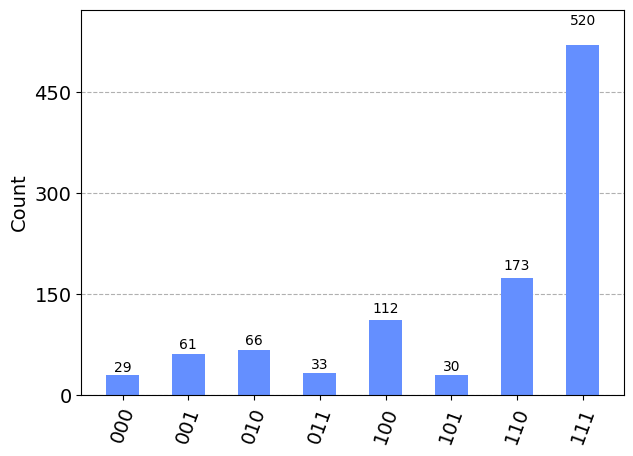

In [47]:
final_circuit = max_3_sat_circuit(ex_cnf, p=1)
final_circuit = final_circuit.bind_parameters(opt_params)
backend = Aer.get_backend('qasm_simulator')
counts = backend.run(final_circuit, shots=1024).result().get_counts()
plot_histogram(counts)

**Example 2**

$$
\be 
c_1 &= x_0 \lor x_1 \lor x_2&, \space w_1 = 1 \\
c_2 &= x_0 \lor x_1 \lor \neg x_2&, \space w_2 = 1  \\
c_3 &= x_0 \lor \neg x_1 \lor x_2&, \space w_3 = 10  \\
c_4 &= x_0 \lor \neg x_1 \lor \neg x_2 &, \space w_4 = 10  \\
c_5 &= \neg x_0 \lor x_1 \lor x_2&, \space w_5 = 10 \\
c_6 &= \neg x_0 \lor x_1 \lor \neg x_2 &, \space w_6 = 10  \\
c_7 &= \neg x_0 \lor \neg x_1 \lor x_2 &, \space w_7 = 10 \\
c_8 &= \neg x_0 \lor \neg x_1 \lor \neg x_2 &, \space w_8 = 10
\en
$$

These clauses are unsatisfiable. However, they are maximally satisfied by $\ux = 000$ and $\ux = 001$

We construct them and verify the above assignments are maximal:

In [48]:
x0 = Variable(0, False) 
x1 = Variable(1, False) 
x2 = Variable(2, False) 
notx0 = Variable(0, True) 
notx1 = Variable(1, True) 
notx2 = Variable(2, True) 

ex_c1 = Clause([x0, x1, x2], 1)
ex_c2 = Clause([x0, x1, notx2], 1)
ex_c3 = Clause([x0, notx1, x2], 10)
ex_c4 = Clause([x0, notx1, notx2], 10)
ex_c5 = Clause([notx0, x1, x2], 10)
ex_c6 = Clause([notx0, x1, notx2], 10)
ex_c7 = Clause([notx0, notx1, x2], 10)
ex_c8 = Clause([notx0, notx1, notx2], 10)

ex_cnf = CNF([ex_c1, ex_c2, ex_c3, ex_c4, ex_c5, ex_c6, ex_c7, ex_c8], 3)
print(ex_cnf)
for ass in [a + b + c for a in "01" for b in "01" for c in "01"]:
  print(f'{ass} assignment weight: {ex_cnf.assignment_weight(ass)}')

(x0 ∨ x1 ∨ x2)∧
(x0 ∨ x1 ∨ ¬x2)∧
(x0 ∨ ¬x1 ∨ x2)∧
(x0 ∨ ¬x1 ∨ ¬x2)∧
(¬x0 ∨ x1 ∨ x2)∧
(¬x0 ∨ x1 ∨ ¬x2)∧
(¬x0 ∨ ¬x1 ∨ x2)∧
(¬x0 ∨ ¬x1 ∨ ¬x2)

000 assignment weight: 61
001 assignment weight: 61
010 assignment weight: 52
011 assignment weight: 52
100 assignment weight: 52
101 assignment weight: 52
110 assignment weight: 52
111 assignment weight: 52


In [49]:
opt_params = max_sat_params(ex_cnf, p=1, init_params=[1.0, 1.0])

     fun: -56.4033203125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([1.073298  , 0.99773881])


We plot the output of a circuit with the bound optimal parameters and as expected $\ket{000}$ and $\ket{001}$ are the most frequently measured states.

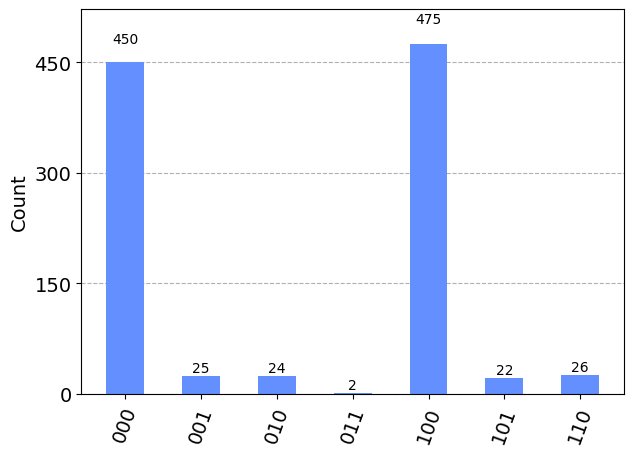

In [50]:
final_circuit = max_3_sat_circuit(ex_cnf, p=1)
final_circuit = final_circuit.bind_parameters(opt_params)
backend = Aer.get_backend('qasm_simulator')
counts = backend.run(final_circuit, shots=1024).result().get_counts()
plot_histogram(counts)

# Bibliography #
<a name="cite_note-1"></a>[HAD21]. [^](#cite_ref-1)Stuart Hadfield. On the representation of Boolean and real functions as Hamiltonians for quantum computing.